# Keras for Text Classification

## Learning Objectives
1. Learn how to create a text classification datasets using BigQuery.
1. Learn how to tokenize and integerize a corpus of text for training in Keras.
1. Learn how to do one-hot-encodings in Keras.
1. Learn how to use embedding layers to represent words in Keras.
1. Learn about the bag-of-word representation for sentences.
1. Learn how to use DNN/CNN/RNN model to classify text in keras.

## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset we constructed in the first task of the lab.

In the next step, we will load and pre-process the texts and labels so that they are suitable to be fed to a Keras model. For the texts of the titles we will learn how to split them into a list of tokens, and then how to map each token to an integer using the Keras Tokenizer class. What will be fed to our Keras models will be batches of padded list of integers representing the text. For the labels, we will learn how to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will explore a few possible models to do the title classification. All models will be fed padded list of integers, and all models will start with a Keras Embedding layer that transforms the integer representing the words into dense vectors.

The first model will be a simple bag-of-word DNN model that averages up the word vectors and feeds the tensor that results to further dense layers. Doing so means that we forget the word order (and hence that we consider sentences as a “bag-of-words”). In the second and in the third model we will keep the information about the word order using a simple RNN and a simple CNN allowing us to achieve the same performance as with the DNN model but in much fewer epochs.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/keras_for_text_classification.ipynb).

In [1]:
import os

from google.cloud import bigquery
import pandas as pd

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [3]:
PROJECT = "qwiklabs-gcp-02-61a3f0385ee9"  # Replace with your PROJECT
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION
SEED = 0

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://console.cloud.google.com/bigquery?project=bigquery-public-data&page=table&t=full&d=hacker_news&p=bigquery-public-data&redirect_from_classic=true) contains all headlines from the sites inception in October 2006 until October 2015. 

### Lab Task 1a: 
Complete the query below to create a sample dataset containing the `url`, `title`, and `score` of articles from the public dataset `bigquery-public-data.hacker_news.full`. Use a WHERE clause to restrict to only those articles with
* title length greater than 10 characters
* score greater than 10
* url length greater than 0 characters

In [4]:
%%bigquery --project $PROJECT
-- This line specifies that the following SQL query will be executed in Google BigQuery.
-- The `--project $PROJECT` flag indicates that the query will run in the specified Google Cloud project.

SELECT
    url, title, score
    -- Selects three columns from the table: `url`, `title`, and `score`.
    -- These columns represent the URL of the post, the title of the post, and the score (upvotes) of the post, respectively.

FROM
    `bigquery-public-data.hacker_news.full`
    -- Specifies the table to query. In this case, it's the `full` table from the `hacker_news` dataset in the `bigquery-public-data` project.
    -- This table contains data about posts on Hacker News.

WHERE
    LENGTH(title) > 10
    -- Filters the results to include only rows where the length of the `title` is greater than 10 characters.
    -- This ensures that the titles are sufficiently descriptive.

    AND score > 10
    -- Further filters the results to include only rows where the `score` (number of upvotes) is greater than 10.
    -- This ensures that only popular or high-quality posts are included.

    AND LENGTH(url) > 0
    -- Filters the results to include only rows where the `url` is not empty (i.e., the length of the URL is greater than 0).
    -- This ensures that only posts with a valid URL are included.

LIMIT 10
    -- Limits the number of rows returned by the query to 10.
    -- This is useful for testing or when you only need a small sample of the data.

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,url,title,score
0,http://mindaverse.com/2008/12/18/save-time-wit...,Using a Virtual Assistant to become more produ...,12
1,https://arstechnica.com/gaming/2024/04/a-touch...,Delta takes flight: Apple-approved Nintendo em...,23
2,https://www.discoursemagazine.com/p/zoning-out...,Zoning Out American Families,22
3,https://twitter.com/winglian/status/1783122644...,Llama3 – 65k Context Window with great recall,23
4,https://github.com/gateweaver/gateweaver,Show HN: I've developed an open-source proxy s...,11
5,https://technicshistory.com/2024/04/25/twiligh...,"Twilight of the Age of Steam, Part 2: Petroleu...",17
6,http://venturebeat.com/2012/05/22/jon-radoff-t...,Game of Thrones Anti-Social Game,12
7,https://petapixel.com/2024/04/18/this-viral-ki...,Viral Kickstarter Telephoto Camera Makes Impos...,26
8,http://news.yahoo.com/software-exec-charged-le...,Silicon Valley Exec Caught Stealing Legos from...,11
9,https://www.threads.net/@moskov/post/C6KW_Odvky0,Dustin Moskovitz says Tesla is the next Enron,11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

### Lab task 1b:
Complete the query below to count the number of titles within each 'source' category. Note that to grab the 'source' of the article we use the a regex command on the `url` of the article. To count the number of articles you'll use a `GROUP BY` in sql, and we'll also restrict our attention to only those articles whose title has greater than 10 characters.

In [5]:
%%bigquery --project $PROJECT
-- This line specifies that the following SQL query will be executed in Google BigQuery.
-- The `--project $PROJECT` flag indicates that the query will run in the specified Google Cloud project.

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[SAFE_OFFSET(1)] AS source,
    -- Extracts the domain name from the URL and processes it to get the main source (e.g., "google" from "news.google.com").
    -- Steps:
    -- 1. `REGEXP_EXTRACT(url, '.*://(.[^/]+)/')`: Extracts the domain part of the URL (e.g., "news.google.com").
    -- 2. `SPLIT(..., '.')`: Splits the domain into parts using '.' as the delimiter (e.g., ["news", "google", "com"]).
    -- 3. `ARRAY_REVERSE(...)`: Reverses the array (e.g., ["com", "google", "news"]).
    -- 4. `[SAFE_OFFSET(1)]`: Selects the second element from the reversed array (e.g., "google").
    -- This gives the main source of the URL (e.g., "google" for "news.google.com").

    COUNT(title) AS num_articles
    -- Counts the number of articles (titles) for each source.

FROM
    `bigquery-public-data.hacker_news.full`
    -- Specifies the table to query. In this case, it's the `full` table from the `hacker_news` dataset in the `bigquery-public-data` project.
    -- This table contains data about posts on Hacker News.

WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    -- Filters the results to include only rows where the domain ends with `.com`.
    -- Steps:
    -- 1. `REGEXP_EXTRACT(url, '.*://(.[^/]+)/')`: Extracts the domain part of the URL.
    -- 2. `REGEXP_CONTAINS(..., '.com$')`: Checks if the domain ends with `.com`.

    AND LENGTH(title) > 10
    -- Further filters the results to include only rows where the length of the `title` is greater than 10 characters.
    -- This ensures that the titles are sufficiently descriptive.

GROUP BY
    source
    -- Groups the results by the `source` (e.g., "google", "yahoo", etc.).
    -- This allows the `COUNT(title)` to calculate the number of articles for each source.

ORDER BY num_articles DESC
    -- Orders the results by `num_articles` in descending order.
    -- This ensures that the sources with the most articles appear first.

LIMIT 100
    -- Limits the number of rows returned by the query to 100.
    -- This ensures that only the top 100 sources by article count are returned.

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,source,num_articles
0,github,173769
1,medium,132979
2,youtube,124464
3,nytimes,82624
4,blogspot,61730
...,...,...
95,msn,3066
96,nextplatform,3061
97,atlasobscura,3040
98,anandtech,3013


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [6]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [7]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


,title,source
0,show hn tastebin a pastebin with taste i.e....,github
1,embed the php interpreter in python,github
2,a simple keyframe-based animation framework fo...,github
3,show hn command line json-based music player ...,github
4,show hn ec-crypt secure file-based messagi...,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [8]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 315085 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [9]:
title_dataset.source.value_counts()

source
github        173769
nytimes        82624
techcrunch     58692
Name: count, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [12]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [14]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

### Lab Task 1c:
Use `.sample` to create a sample dataset of 1,000 articles from the full dataset. Use `.value_counts` to see how many articles are contained in each of the three source categories?

In [15]:
# Take a random sample of 1000 rows from the `title_dataset` DataFrame.
# This is useful for reducing the size of the dataset while maintaining its statistical properties.
# The `sample(n=1000)` function randomly selects 1000 rows without replacement.
sample_title_dataset = title_dataset.sample(n=1000)

# Calculate the frequency of each unique value in the `source` column of the sampled dataset.
# The `value_counts()` function returns a Series where:
# - The index represents the unique values in the `source` column.
# - The values represent the count of occurrences of each unique value.
# This helps in understanding the distribution of sources in the sampled dataset.
sample_title_dataset.source.value_counts()

source
github        574
nytimes       237
techcrunch    189
Name: count, dtype: int64

Let's write the sample datatset to disk.

In [16]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [17]:
sample_title_dataset.head()

,title,source
292837,online art store gets funded - artix 2.0,techcrunch
292555,mark zuckerberg facebook will not go public a...,techcrunch
86046,show hn a simple go logger. no dependencies ...,github
25696,show hn kreact a kotlin redux-like framework...,github
300918,everything you need to know about the mobile e...,techcrunch


In [18]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import (
    Embedding,
    Flatten,
    GRU,
    Conv1D,
    Lambda,
    Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2025-01-14 01:54:44.666962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-14 01:54:44.956054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-14 01:54:45.023801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 01:54:45.580310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.17.0


In [19]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [20]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

Our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times).

In [21]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,how companies learn your secrets,nytimes
1,a pytorch-based speech toolkit,github
2,google shuts out competitors on android hardly,nytimes
3,is-negative,github
4,tutanota forced to monitor an email account af...,techcrunch


## Integerize the texts

The first thing we need to do is to find how many words we have in our dataset (`VOCAB_SIZE`), how many titles we have (`DATASET_SIZE`), and what the maximum length of the titles we have (`MAX_LEN`) is. Keras offers the `Tokenizer` class in its `keras.preprocessing.text` module to help us with that:

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df.title)

In [23]:
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)
integerized_titles[:3]

[[24, 270, 412, 14, 802],
 [1, 770, 45, 691, 488],
 [20, 1593, 84, 6534, 12, 90, 15857]]

In [24]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

101805

In [25]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

315085

In [26]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
MAX_LEN

26

Let's now implement a function `create_sequence` that will 
* take as input our titles as well as the maximum sentence length and 
* returns a list of the integers corresponding to our tokens padded to the sentence maximum length

Keras has the helper functions `pad_sequence` for that on the top of the tokenizer methods.

### Lab Task #2:
Complete the code in the `create_sequences` function below to
* create text sequences from `texts` using the tokenizer we created above 
* pad the end of those text sequences to have length `max_len`

In [27]:
# TODO 1
def create_sequences(texts, max_len=MAX_LEN):
    """
    Converts a list of text samples into sequences of integers and pads them to a fixed length.

    Args:
        texts (list of str): A list of text samples to convert into sequences.
        max_len (int): The maximum length of the padded sequences. Defaults to `MAX_LEN`.

    Returns:
        numpy.ndarray: A 2D array of padded sequences, where each row corresponds to a text sample.
    """
    # Step 1: Convert the texts into sequences of integers using a tokenizer.
    # The tokenizer maps each word in the text to a unique integer.
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Step 2: Pad the sequences to ensure they all have the same length (`max_len`).
    # Shorter sequences are padded with zeros at the end, and longer sequences are truncated.
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    
    return padded_sequences

In [28]:
sequences = create_sequences(titles_df.title[:3])
sequences

array([[   24,   270,   412,    14,   802,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    1,   770,    45,   691,   488,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   20,  1593,    84,  6534,    12,    90, 15857,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [31]:
titles_df.source[:4]

0    nytimes
1     github
2    nytimes
3     github
Name: source, dtype: object

We now need to write a function that 
* takes a title source and
* returns the corresponding one-hot encoded vector

Keras `to_categorical` is handy for that.

In [39]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

### Lab Task #3:
Complete the code in the `encode_labels` function below to
* create a list that maps each `source` in `sources` to its corresponding numeric value using the dictionary `CLASSES` above
* use the Keras function to one-hot encode the variable classes

In [41]:
# TODO 2
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes)
    return one_hots

In [42]:
encode_labels(titles_df.source[:4])

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

## Preparing the train/test splits

Let's split our data into train and test splits:

In [44]:
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per classes.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.


In [45]:
sources_train.value_counts()

source
github        139109
nytimes        66109
techcrunch     46850
Name: count, dtype: int64

In [46]:
sources_valid.value_counts()

source
github        34660
nytimes       16515
techcrunch    11842
Name: count, dtype: int64

Using `create_sequence` and `encode_labels`, we can now prepare the
training and validation data to feed our models.

The features will be
padded list of integers and the labels will be one-hot-encoded 3D vectors.

In [47]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [48]:
X_train[:3]

array([[   24,   270,   412,    14,   802,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    1,   770,    45,   691,   488,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   20,  1593,    84,  6534,    12,    90, 15857,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [49]:
Y_train[:3]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

## Building a DNN model

The build_dnn_model function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

### Lab Tasks #4, #5, and #6:
Create a Keras Sequential model with three layers:
* The first layer should be an embedding layer with output dimension equal to `embed_dim`.
* The second layer should use a Lambda layer to create a bag-of-words representation of the sentences by computing the mean.
* The last layer should use a Dense layer to predict which class the example belongs to.

In [50]:
def build_dnn_model(embed_dim):
    """
    Builds a Deep Neural Network (DNN) model for text classification.

    Args:
        embed_dim (int): The dimension of the embedding vectors.

    Returns:
        keras.Sequential: A compiled Keras Sequential model.
    """
    model = Sequential([
        # TODO 3: Add an Embedding layer.
        # This layer converts integer-encoded words into dense vectors of fixed size (`embed_dim`).
        # - `VOCAB_SIZE + 1`: The size of the vocabulary, plus one for padding (index 0).
        # - `embed_dim`: The dimension of the embedding vectors.
        # - `input_shape=[MAX_LEN]`: The input shape is the maximum length of the sequences.
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN]),

        # TODO 4: Add a Lambda layer to compute the mean of the embeddings.
        # This layer reduces the sequence of word embeddings into a single vector by taking the mean across the sequence length.
        # - `tf.reduce_mean(x, axis=1)`: Computes the mean along the sequence dimension (axis=1).
        Lambda(lambda x: tf.reduce_mean(x, axis=1)),

        # TODO 5: Add a Dense output layer with softmax activation.
        # This layer produces the final output probabilities for each class.
        # - `N_CLASSES`: The number of output classes.
        # - `activation='softmax'`: Softmax activation is used for multi-class classification.
        Dense(N_CLASSES, activation='softmax')
    ])

    # Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric.
    model.compile(
        optimizer='adam',  # Adam optimizer for gradient descent.
        loss='categorical_crossentropy',  # Loss function for multi-class classification.
        metrics=['accuracy']  # Metric to monitor during training.
    )

    return model

Below we train the model on 100 epochs but adding an `EarlyStopping` callback that will stop the training as soon as the validation loss has not improved after a number of steps specified by `PATIENCE` . Note that we also give the `model.fit` method a Tensorboard callback so that we can later compare all the models using TensorBoard.

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


841/841 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6005 - loss: 0.8583 - val_accuracy: 0.7706 - val_loss: 0.5431
Epoch 2/10
841/841 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8055 - loss: 0.4945 - val_accuracy: 0.8531 - val_loss: 0.3991
Epoch 3/10
841/841 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8640 - loss: 0.3717 - val_accuracy: 0.8737 - val_loss: 0.3362
Epoch 4/10
841/841 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8840 - loss: 0.3135 - val_accuracy: 0.8832 - val_loss: 0.3044
Epoch 5/10
841/841 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8960 - loss: 0.2799 - val_accuracy: 0.8901 - val_loss: 0.2858
Epoch 6/10
841/841 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9038 - loss: 0.2571 - val_accuracy: 0.8940 - val_loss: 0.2739
Epoch 7/10
841/841 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9104 - loss: 0.2399 - val_accuracy: 0.8974 - val_loss: 0.2658
Epoch 8/10
841/841 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9153 - loss: 0.2261 - val_accuracy: 0.8993 - val_

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 26, 10)         │     1,018,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,054,281 (11.65 MB)

 Trainable params: 1,018,093 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,036,188 (7.77 MB)

CPU times: user 2min 4s, sys: 8.46 s, total: 2min 12s
Wall time: 54.8 s


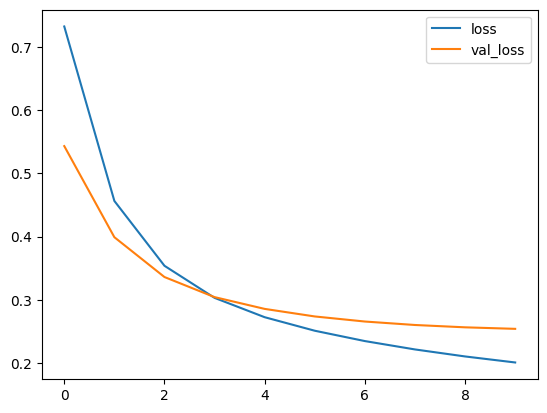

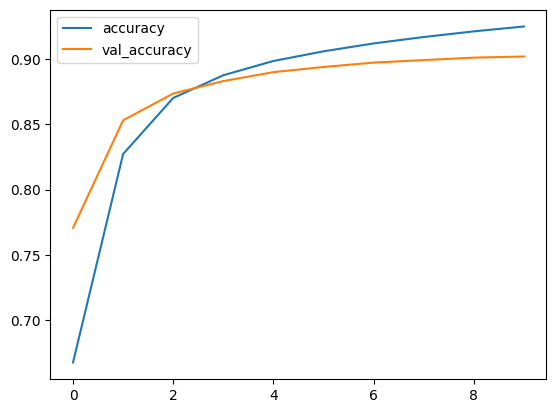

In [53]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 10
EMBED_DIM = 10
PATIENCE = 0

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

## Building a RNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple RNN model with a single `GRU` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


### Lab Task #4 and #6:
Complete the code below to build an RNN model which predicts the article class. The code below is similar to the DNN you created above; however, here we do not need to use a bag-of-words representation of the sentence. Instead, you can pass the embedding layer directly to an RNN/LSTM/GRU layer.

In [55]:
def build_rnn_model(embed_dim, units):
    """
    Builds a Recurrent Neural Network (RNN) model for text classification.

    Args:
        embed_dim (int): The dimension of the embedding vectors.
        units (int): The number of units (neurons) in the GRU layer.

    Returns:
        keras.Sequential: A compiled Keras Sequential model.
    """
    model = Sequential([
        # TODO 3: Add an Embedding layer.
        # This layer converts integer-encoded words into dense vectors of fixed size (`embed_dim`).
        # - `VOCAB_SIZE + 1`: The size of the vocabulary, plus one for padding (index 0).
        # - `embed_dim`: The dimension of the embedding vectors.
        # - `input_shape=[MAX_LEN]`: The input shape is the maximum length of the sequences.
        # - `mask_zero=True`: Ensures that padding values (0) are ignored during computation.
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True),

        # TODO 5: Add a GRU (Gated Recurrent Unit) layer.
        # This layer processes the sequence of word embeddings using a GRU, which is a type of RNN.
        # - `units`: The number of units (neurons) in the GRU layer.
        GRU(units),

        # Add a Dense output layer with softmax activation.
        # This layer produces the final output probabilities for each class.
        # - `N_CLASSES`: The number of output classes.
        # - `activation='softmax'`: Softmax activation is used for multi-class classification.
        Dense(N_CLASSES, activation='softmax')
    ])

    # Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric.
    model.compile(
        optimizer='adam',  # Adam optimizer for gradient descent.
        loss='categorical_crossentropy',  # Loss function for multi-class classification.
        metrics=['accuracy']  # Metric to monitor during training.
    )

    return model

Let's train the model with early stoping as above. 

Observe that we obtain the same type of accuracy as with the DNN model, but in less epochs (~3 v.s. ~20 epochs):

Epoch 1/5
841/841 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.7176 - loss: 0.6120 - val_accuracy: 0.8976 - val_loss: 0.2666
Epoch 2/5
841/841 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9106 - loss: 0.2354 - val_accuracy: 0.9040 - val_loss: 0.2523
Epoch 3/5
841/841 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9309 - loss: 0.1845 - val_accuracy: 0.9041 - val_loss: 0.2614


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 26, 10)         │     1,018,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,058,367 (11.67 MB)

 Trainable params: 1,019,455 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,038,912 (7.78 MB)

CPU times: user 2min 52s, sys: 10.5 s, total: 3min 2s
Wall time: 1min 2s


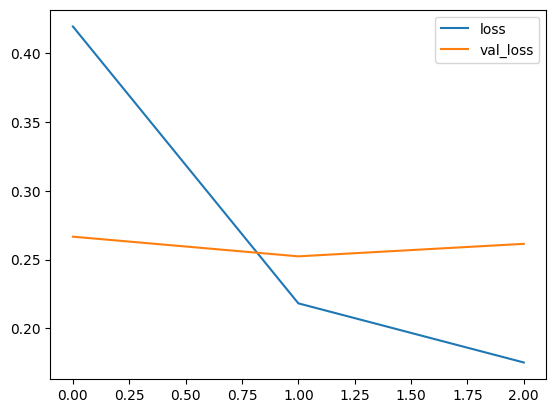

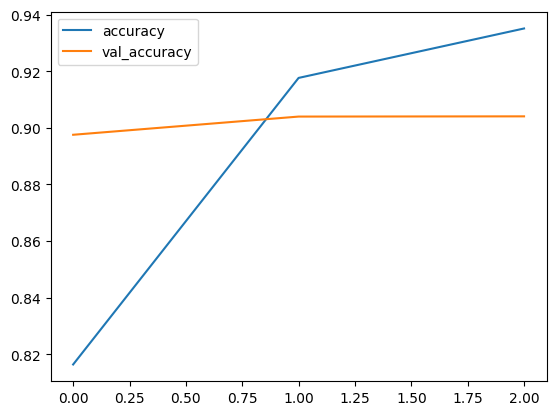

In [57]:
%%time
# This is a Jupyter Notebook magic command to measure the execution time of the cell.

# Set a random seed for reproducibility in TensorFlow.
tf.random.set_seed(33)

# Define the directory for saving the RNN model logs.
MODEL_DIR = os.path.join(LOGDIR, 'rnn')

# Remove the existing directory and its contents to start fresh.
shutil.rmtree(MODEL_DIR, ignore_errors=True)

# Define training hyperparameters.
EPOCHS = 5  # Number of epochs to train the model.
BATCH_SIZE = 300  # Number of samples per batch.
EMBED_DIM = 10  # Dimension of the embedding vectors.
UNITS = 16  # Number of units in the RNN layer.
PATIENCE = 0  # Patience for early stopping (0 means no early stopping).

# Build the RNN model using the specified embedding dimension and RNN units.
rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

# Train the RNN model.
history = rnn_model.fit(
    X_train, Y_train,  # Training data (features and labels).
    epochs=EPOCHS,  # Number of epochs.
    batch_size=BATCH_SIZE,  # Batch size.
    validation_data=(X_valid, Y_valid),  # Validation data (features and labels).
    callbacks=[
        EarlyStopping(patience=PATIENCE),  # Early stopping callback (not used if PATIENCE=0).
        TensorBoard(MODEL_DIR)  # TensorBoard callback to log training progress.
    ],
)

# Plot the training and validation loss over epochs.
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

# Plot the training and validation accuracy over epochs.
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

# Print a summary of the RNN model architecture.
rnn_model.summary()

## Build a CNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple CNN model with a single `Conv1D` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model, but we need to add a `Flatten` layer betwen the convolution and the softmax layer.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


### Lab Task #4 and #6
Complete the code below to create a CNN model for text classification. This model is similar to the previous models in that you should start with an embedding layer. However, the embedding next layers should pass through a 1-dimensional convolution and ultimately the final fully connected, dense layer. Use the arguments of the `build_cnn_model` function to set up the 1D convolution layer. 

In [58]:
def build_cnn_model(embed_dim, filters, ksize, strides):
    """
    Builds a Convolutional Neural Network (CNN) model for text classification.

    Args:
        embed_dim (int): The dimension of the embedding vectors.
        filters (int): The number of filters in the Conv1D layer.
        ksize (int): The size of the convolutional kernel.
        strides (int): The stride length of the convolution.

    Returns:
        keras.Sequential: A compiled Keras Sequential model.
    """
    model = Sequential([
        # TODO 3: Add an Embedding layer.
        # This layer converts integer-encoded words into dense vectors of fixed size (`embed_dim`).
        # - `VOCAB_SIZE + 1`: The size of the vocabulary, plus one for padding (index 0).
        # - `embed_dim`: The dimension of the embedding vectors.
        # - `input_shape=[MAX_LEN]`: The input shape is the maximum length of the sequences.
        # - `mask_zero=True`: Ensures that padding values (0) are ignored during computation.
        Embedding(
            VOCAB_SIZE + 1,
            embed_dim,
            input_shape=[MAX_LEN],
            mask_zero=True),

        # TODO 5: Add a 1D Convolutional layer (Conv1D).
        # This layer applies convolutional filters to the sequence of word embeddings.
        # - `filters`: The number of filters (output channels) in the Conv1D layer.
        # - `kernel_size=ksize`: The size of the convolutional kernel.
        # - `strides=strides`: The stride length of the convolution.
        # - `activation='relu'`: ReLU activation is used to introduce non-linearity.
        Conv1D(
            filters=filters,
            kernel_size=ksize,
            strides=strides,
            activation='relu',
        ),

        # TODO 5: Add a Flatten layer.
        # This layer flattens the output of the Conv1D layer into a 1D vector.
        # This is necessary to connect the convolutional output to the dense layer.
        Flatten(),

        # Add a Dense output layer with softmax activation.
        # This layer produces the final output probabilities for each class.
        # - `N_CLASSES`: The number of output classes.
        # - `activation='softmax'`: Softmax activation is used for multi-class classification.
        Dense(N_CLASSES, activation='softmax')
    ])

    # Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric.
    model.compile(
        optimizer='adam',  # Adam optimizer for gradient descent.
        loss='categorical_crossentropy',  # Loss function for multi-class classification.
        metrics=['accuracy']  # Metric to monitor during training.
    )

    return model

Let's train the model. 

Again we observe that we get the same kind of accuracy as with the DNN model but in many fewer steps.



Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


841/841 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7448 - loss: 0.5691 - val_accuracy: 0.8992 - val_loss: 0.2574
Epoch 2/5
841/841 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9112 - loss: 0.2284 - val_accuracy: 0.9044 - val_loss: 0.2509
Epoch 3/5
841/841 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9335 - loss: 0.1769 - val_accuracy: 0.9030 - val_loss: 0.2665


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 26, 5)          │       509,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 200)        │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │         7,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,558,301 (5.94 MB)

 Trainable params: 519,433 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,038,868 (3.96 MB)

CPU times: user 58.4 s, sys: 3.49 s, total: 1min 1s
Wall time: 23.6 s


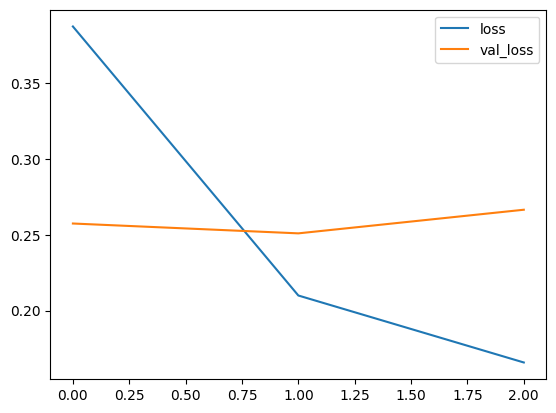

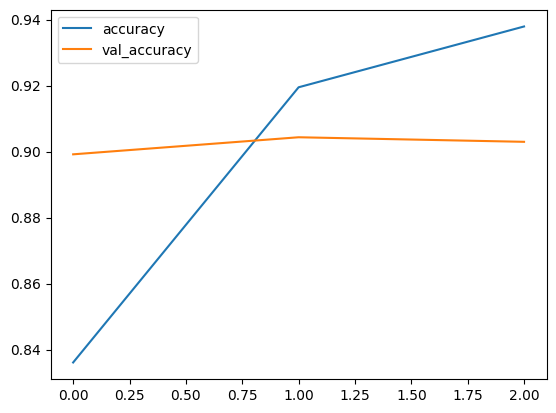

In [60]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'cnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 5
BATCH_SIZE = 300
EMBED_DIM = 5
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 0


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']].plot()

cnn_model.summary()

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License